## Análisis Exploratorio de Datos (EDA)
---
La data historica descarga de la pagina oficial de la Bolsa de valores de Lima es del 31-10-24 al 31-10-25.

[Link Bolsa de Valores de Lima](https://www.bvl.com.pe/emisores/listado-emisores)

La Empresas analizadas son:

- Alicorp S.A.A  (productor de alimentos)
- Credicorp L.T.D  (holding financiero, controla BCP, AFP integra, Pacifico Vida)
- Ferreycorp S.A.A  (Distribuidora de Caterpillar - Maquinaria Pesada)
- Southern Cooper Corporation  (Minera - Produce cobre)

---

## [1.1] Calculo de Rendimientos (W) -  Manualmente

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('DATA_UNIFICADA.csv')

# calcular rendimientos : (X_t - X_t-1) / X_t-1
rendimientos = df.copy()
rendimientos.set_index('Fecha', inplace=True)

for col in rendimientos.columns:
    rendimientos[col] = (rendimientos[col] - rendimientos[col].shift(1)) / rendimientos[col].shift(1)

# eliminar primera fila (NaN porque no tiene dia anterior)
rendimientos = rendimientos.dropna()

rendimientos.head()

,ALICORP,CREDICORP,FERREYCORP,SOUTHERN
Fecha,,,,
2024-11-04,-0.015152,-0.016996,-0.006623,-0.024412
2024-11-05,0.000000,-0.013279,-0.010000,0.020091
2024-11-06,-0.004615,-0.001373,0.010101,-0.012534
2024-11-07,0.043277,0.010451,0.000000,-0.002720
2024-11-08,-0.010370,-0.004682,0.000000,0.000000


## [1.2] Calculo de Rendimientos (W) - Librerias

             ALICORP  CREDICORP  FERREYCORP  SOUTHERN
Fecha                                                
2024-11-04 -0.015152  -0.016996   -0.006623 -0.024412
2024-11-05  0.000000  -0.013279   -0.010000  0.020091
2024-11-06 -0.004615  -0.001373    0.010101 -0.012534
2024-11-07  0.043277   0.010451    0.000000 -0.002720
2024-11-08 -0.010370  -0.004682    0.000000  0.000000
2024-11-11  0.005988   0.011814    0.000000 -0.026364
2024-11-12 -0.013393   0.005135    0.000000 -0.021475
2024-11-13 -0.004525   0.015004   -0.006667 -0.023855
2024-11-14  0.000000  -0.000371   -0.003356 -0.012708
2024-11-15  0.000000  -0.006466    0.003367 -0.007921
2024-11-18  0.006061   0.018938    0.000000 -0.009980
2024-11-19 -0.006024   0.013141    0.003356  0.022681
2024-11-20 -0.009091  -0.003152   -0.010033  0.021981
2024-11-21  0.012232  -0.004666    0.010135 -0.000772
2024-11-22  0.004532   0.032813   -0.006689 -0.025097

Dimensión: (250, 4)


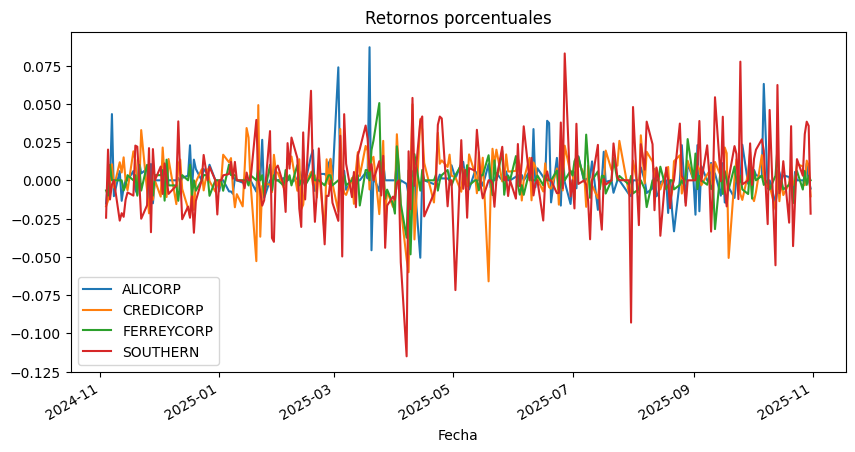

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. CARGA
df = pd.read_csv("DATA_UNIFICADA.csv")

# 2. FECHA COMO ÍNDICE
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df = df.set_index("Fecha")

# 3. CONVERSIÓN NUMÉRICA
df = df.apply(pd.to_numeric, errors="coerce")

# 4. VARIACIÓN PORCENTUAL (SIN FILL)
W = df.pct_change(fill_method=None)

# 5. LIMPIEZA CORRECTA
# Eliminamos SOLO filas completamente vacías
W = W.dropna(how="all")



## [2.1] Matriz de covarianza - Manualmente

In [3]:
import pandas as pd
import numpy as np

# convertir a matriz numpy
R = rendimientos.values
T = len(R)  # numero de dias de datos

mean = np.mean(R, axis=0)  # promedio por activo

# matriz de covarianza manual 
cov = (R - mean).T @ (R - mean) / (T - 1)

# convertir a dataframe con nombres de columnas y filas
cov_df = pd.DataFrame(cov, 
        index=['ALICORP', 'CREDICORP', 'FERREYCORP', 'SOUTHERN'],
        columns=['ALICORP', 'CREDICORP', 'FERREYCORP', 'SOUTHERN'])

# impresion de la matriz de covarianza
cov_df

,ALICORP,CREDICORP,FERREYCORP,SOUTHERN
ALICORP,0.000175,-0.000010,0.000001,-0.000012
CREDICORP,-0.000010,0.000252,0.000001,0.000111
FERREYCORP,0.000001,0.000001,0.000086,0.000026
SOUTHERN,-0.000012,0.000111,0.000026,0.000612


## [2.2] Matriz de Covarianza - Librerias

In [4]:
Q = W.cov()
print(Q)

             ALICORP  CREDICORP  FERREYCORP  SOUTHERN
ALICORP     0.000175  -0.000010    0.000001 -0.000012
CREDICORP  -0.000010   0.000252    0.000001  0.000111
FERREYCORP  0.000001   0.000001    0.000086  0.000026
SOUTHERN   -0.000012   0.000111    0.000026  0.000612


## [3.1] Descomposicion Choleski - Manualmente

In [5]:
import numpy as np
import pandas as pd


# hacemos una copia, con lo cual trabajaremos
cov = cov_df.to_numpy(copy=True)

# comprobaciones de simetría y autovalores

# simetria numerica
is_symmetric = np.allclose(cov, cov.T, atol=1e-12, rtol=1e-12)

# autovalores (para matrices simetricas usa eigvalsh)
eigvals = np.linalg.eigvalsh(cov)

# tolerancia numerica dependiente de la escala de la matriz
scale = max(1.0, np.linalg.norm(cov, ord=2))
tol = 1e-12 * scale

# es semidefinida positiva y simetrica(PSD) si todos los autovalores >= -tol
is_psd = np.all(eigvals >= -tol)

print("######   Comprobacion de la matriz Cov  para descomposicion ######")
print("La matriz Cov es simetrica:", is_symmetric)
print("Los autovalores son:", eigvals)
print("La matriz Cov es semidefinida positiva (numéricamente):", is_psd)

# descomposicion Cholesky
#   - Si es SPD (lambda_min > tol), Cholesky directo
#   - Si no, añadimos el jitter mínimo necesario para volverla SPD
lam_min = eigvals.min()
n = cov.shape[0]

def cholesky_with_min_jitter(A, lam_min, tol, safety=1e-12):
    """
    Intenta Cholesky directo. Si falla o A no es SPD,
    añade jitter = max(0, -lam_min) + safety * tr(A)/n y reintenta.
    """
    try:
        L = np.linalg.cholesky(A)
        jitter_used = 0.0
        return L, jitter_used
    except np.linalg.LinAlgError:
        pass

    # jitter minimo para empujar el menor autovalor por encima de 0
    jitter = max(0.0, -lam_min) + safety * (np.trace(A)/A.shape[0] if A.shape[0] > 0 else 1.0)
    A_j = A + jitter * np.eye(A.shape[0])
    L = np.linalg.cholesky(A_j)
    return L, jitter

L, jitter = cholesky_with_min_jitter(cov, lam_min, tol)
print("")
print("######   Descomposicion Cholesky de la matriz Cov   ######")
print(f"Valor jitter añadido para descomposicion Cholesky: {jitter:.3e}")

# descomposicion Cholesky
print("Matriz L de descomposicion Cholesky")
L_df = pd.DataFrame(L, index=cov_df.index, columns=[f"c{i+1}" for i in range(n)])
print("\nFactor de Cholesky L (triangular inferior):")
print(L_df)

# verificacion 
recon = L @ L.T
res_norm = np.linalg.norm((cov + jitter*np.eye(n)) - recon, ord='fro')
print("")
print(f"Verificacio de descomposicion: ||A(+jitter) - L L^T||_F = {res_norm:.3e}")


######   Comprobacion de la matriz Cov  para descomposicion ######
La matriz Cov es simetrica: True
Los autovalores son: [8.46701408e-05 1.74019835e-04 2.21675846e-04 6.45164493e-04]
La matriz Cov es semidefinida positiva (numéricamente): True

######   Descomposicion Cholesky de la matriz Cov   ######
Valor jitter añadido para descomposicion Cholesky: 0.000e+00
Matriz L de descomposicion Cholesky

Factor de Cholesky L (triangular inferior):
                  c1        c2        c3        c4
ALICORP     0.013245  0.000000  0.000000  0.000000
CREDICORP  -0.000787  0.015853  0.000000  0.000000
FERREYCORP  0.000108  0.000085  0.009278  0.000000
SOUTHERN   -0.000889  0.006965  0.002734  0.023565

Verificacio de descomposicion: ||A(+jitter) - L L^T||_F = 5.884e-21


## [3.2] Descomposicion Choleski - Librerias

In [6]:
L = np.linalg.cholesky(Q)

print('Descomposicion Choleski\n')
print(L)


Descomposicion Choleski

[[ 1.32450208e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.87340560e-04  1.58526961e-02  0.00000000e+00  0.00000000e+00]
 [ 1.07714025e-04  8.48421340e-05  9.27771256e-03  0.00000000e+00]
 [-8.88664039e-04  6.96549194e-03  2.73374914e-03  2.35647178e-02]]


## [4.1] Definicion de Variable Normal - Librerias

Ploteo de las Variables Aleatorias Normales

[[ 0.67117852  0.54596551  0.33403975 -1.29902018]
 [ 0.52447726  1.16839863  1.30088522 -0.03450756]
 [ 0.51127435 -0.36713135  0.45782295 -1.145813  ]
 ...
 [-0.01781921 -0.24608109 -1.73194101 -0.82070677]
 [ 0.58495262 -0.66618883 -1.54430843  0.98989049]
 [ 0.68793271  0.20879828 -0.30500912  2.18894822]]

Ploteo de las Variables Aleatorias W

[[ 0.00888977  0.00812658  0.00321774 -0.0264914 ]
 [ 0.00694671  0.01810933  0.01222486  0.01041552]
 [ 0.00677184 -0.00622257  0.00427147 -0.02876079]
 ...
 [-0.00023602 -0.00388702 -0.01609125 -0.02577266]
 [ 0.00774771 -0.01102145 -0.01432116  0.01394458]
 [ 0.00911168  0.00276838 -0.00273797  0.05159117]]


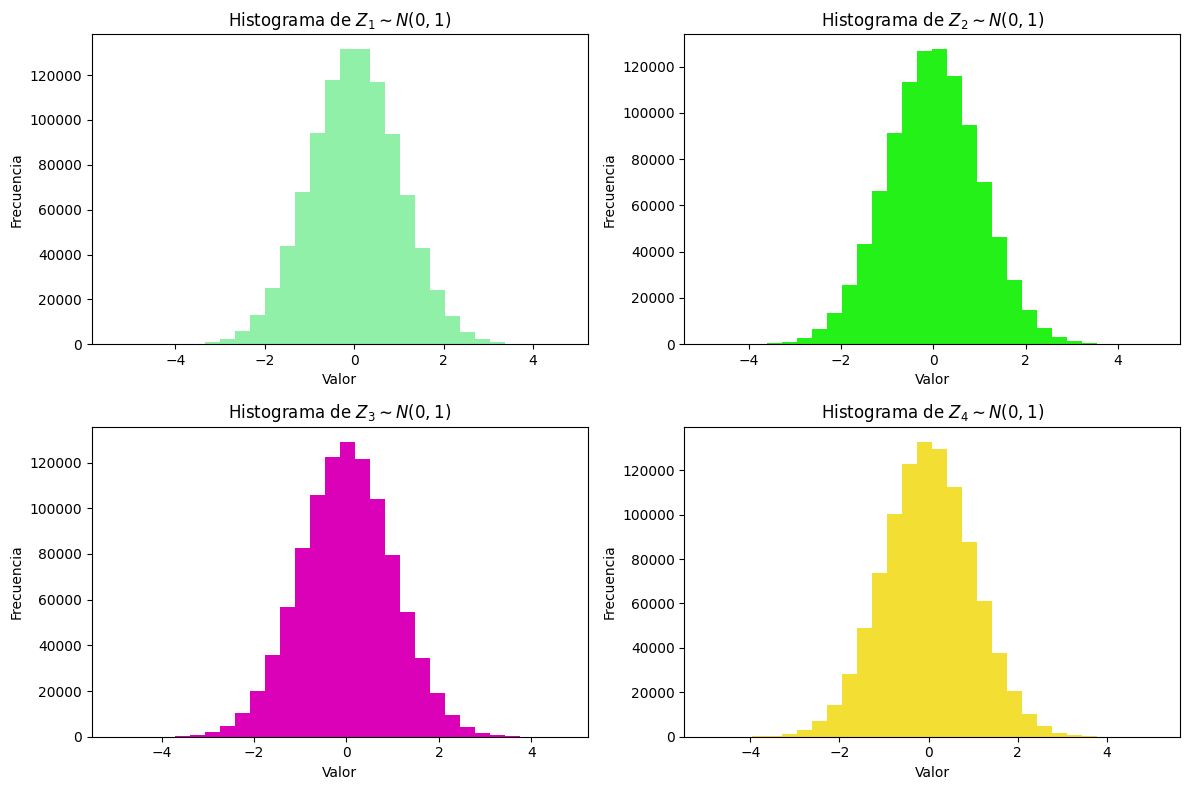

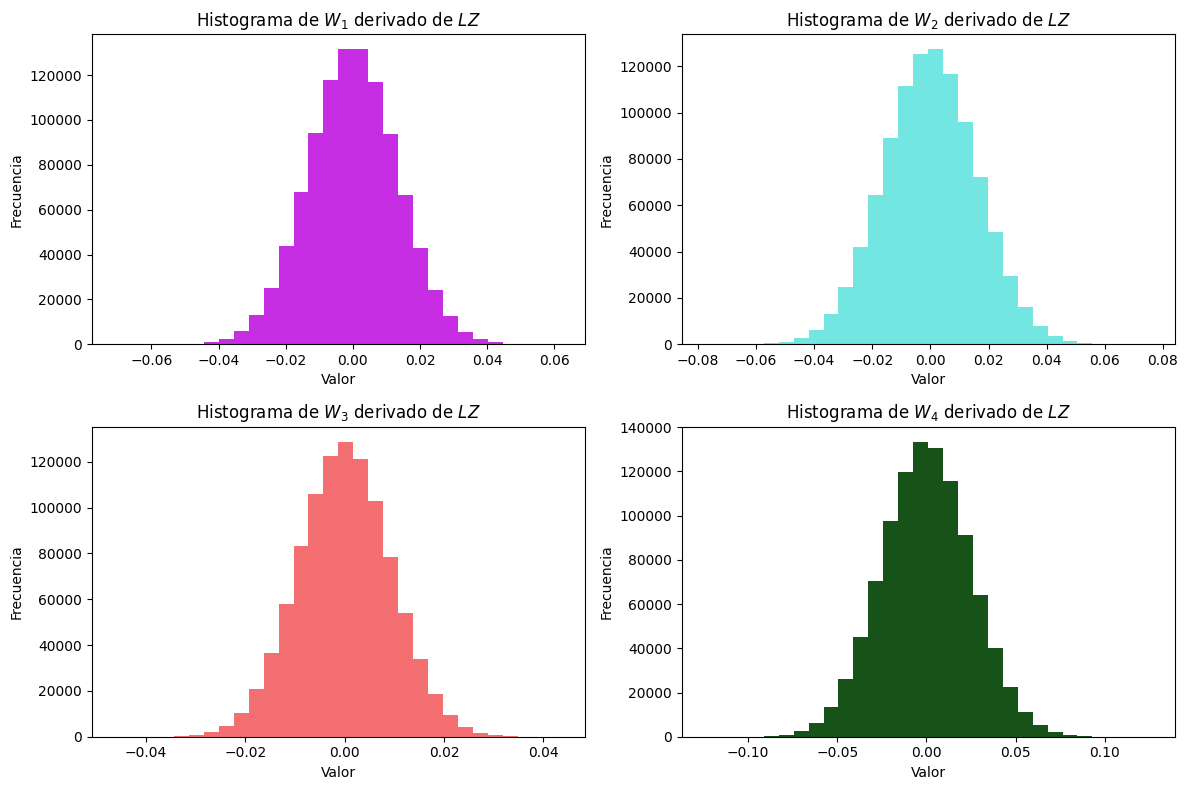

In [29]:
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt
import random

rng = default_rng()
N_muestras = 1000000
Z = rng.standard_normal(size=(N_muestras, Q.shape[1]))
W_sim = Z @ L.T

print("Ploteo de las Variables Aleatorias Normales\n")
print(Z)

print("\nPloteo de las Variables Aleatorias W\n")
print(W_sim)

# funcion color aleatorio
def color_random():
    return (random.random(), random.random(), random.random())

# histogramas de Z_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]
    
    ax.hist(Z[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $Z_{{{i+1}}} \sim N(0,1)$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# histogramas de X_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]

    ax.hist(W_sim[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $W_{{{i+1}}}$ derivado de $LZ$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## [4.2] Definicion de Variable Normal - Manualmente

Ploteo de las Variables Aleatorias Normales

[[ 0.93542523  1.15213299  0.3071145   2.51855716]
 [-0.09645373  0.22038802  1.94340004 -0.92211106]
 [-0.90216983 -0.17620787  0.01532596 -0.38214442]
 ...
 [ 0.67893152  0.67638342  0.56599573 -1.17544056]
 [ 0.09070027  0.7394064  -0.57644354 -0.05229639]
 [-1.51279863 -1.20585231  1.01913443 -0.72565775]]


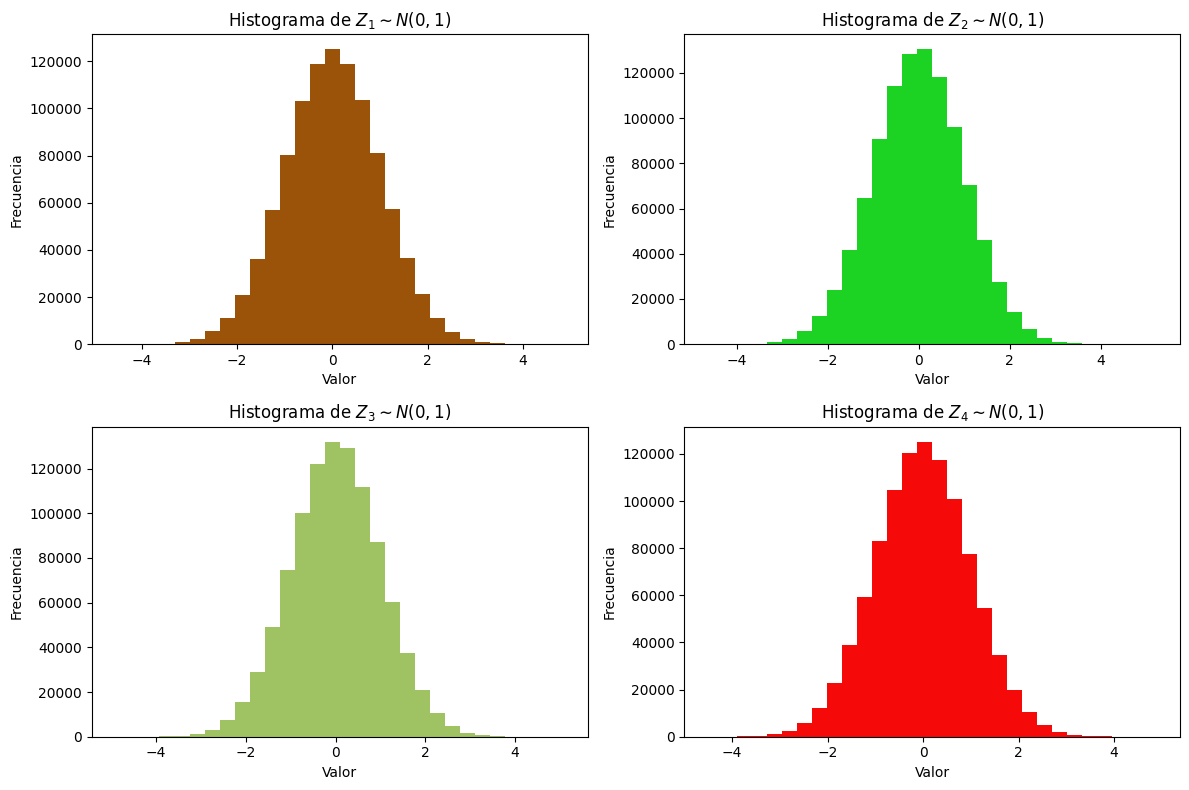

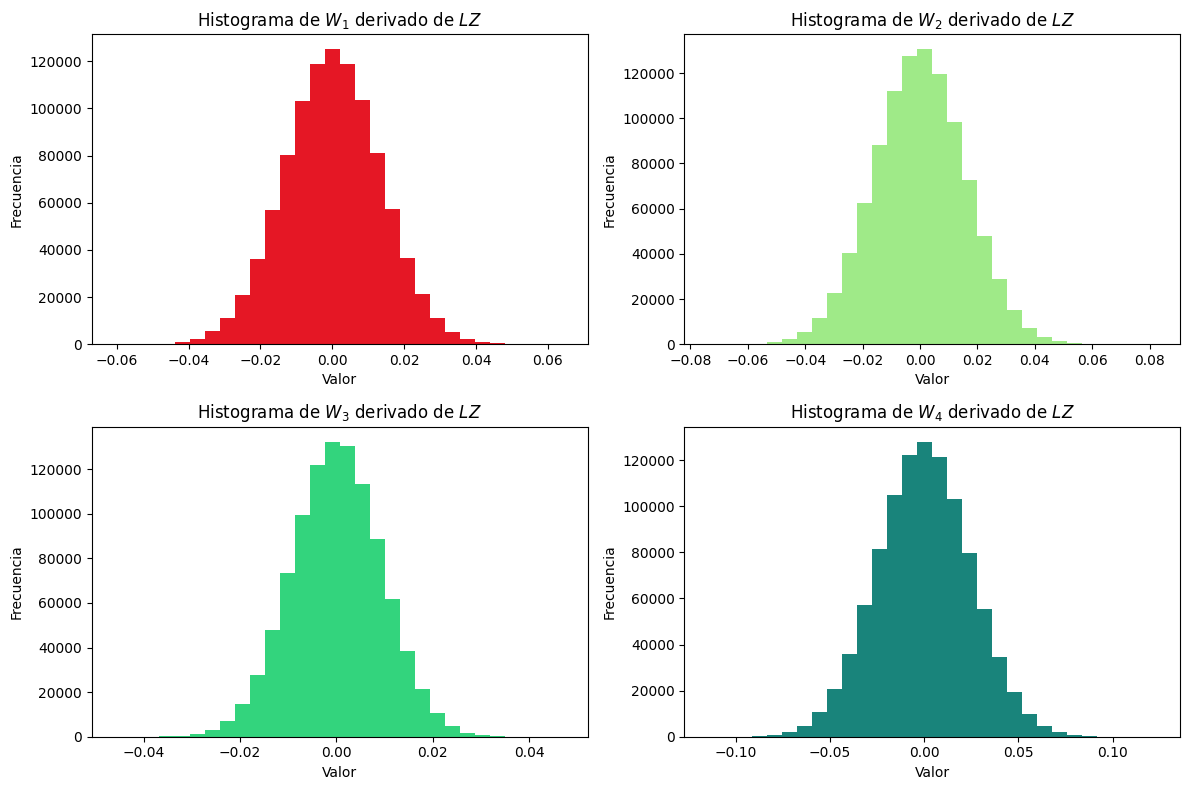

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random

# genera 4 variables aleatorias Z1,...,Z4 iid ~  N(0,1)
n = 1000000 # cada una con 1000000 valores
Z_mat = [np.random.randn(n) for _ in range(4)]

# la matriz Z_mat esta ya ordenado para la multiplicacion
Z = np.column_stack(Z_mat)    # matriz 1000000 × 4

# genera X = L Z   (aplicando a cada fila)
# cada fila Z^(k) se transforma en X^(k)
X = Z @ L.T   # matriz 1000000 × 4 vectorizado

print("Ploteo de las Variables Aleatorias Normales\n")
print(Z)

# funcion color aleatorio
def color_random():
    return (random.random(), random.random(), random.random())

# histogramas de Z_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]
    
    ax.hist(Z[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $Z_{{{i+1}}} \sim N(0,1)$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# histogramas de X_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]

    ax.hist(X[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $W_{{{i+1}}}$ derivado de $LZ$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## [5] Generando el vector C a partir de un simplex empleando una distribucion de dirichlet

In [59]:
rng = np.random.default_rng(42)
d = 4          # dimensión del simplex
n_samples = 1500

# cada fila de samples es un vector en el simplex (suma 1, no negativo)
print("Vector C s")
c = rng.dirichlet(alpha=np.ones(d), size=n_samples)
print(c)

Vector C s
[[3.24675717e-01 3.15490116e-01 3.22049421e-01 3.77847461e-02]
 [1.42322334e-02 2.39185857e-01 2.32155175e-01 5.14426734e-01]
 [3.46972728e-02 4.57950373e-01 3.08212686e-02 4.76531086e-01]
 ...
 [6.58950312e-01 4.04509178e-04 1.41731696e-01 1.98913483e-01]
 [1.51090003e-01 9.14400322e-02 3.58738526e-01 3.98731439e-01]
 [1.68521402e-01 2.32380860e-01 2.34980940e-01 3.64116798e-01]]


## [6] Proyeccion empirica del precio forward a 90 dias

In [67]:
import numpy as np
import pandas as pd

# CARGA DE DATOS
df = pd.read_csv("DATA_UNIFICADA.csv")
print(df)

# FECHA COMO INDICE
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df = df.set_index("Fecha")

# CONVERSIÓN NUMÉRICA
df = df.apply(pd.to_numeric, errors="coerce")

assets = ["ALICORP", "CREDICORP", "FERREYCORP", "SOUTHERN"]
prices = df[assets].copy()

# Retornos diarios simples
returns = prices.pct_change(fill_method=None).dropna(how="all")

# Matriz de covarianzas empírica (diaria)
Sigma = returns.cov().values   # 4x4

# Cholesky
L = np.linalg.cholesky(Sigma)

# Estimación empírica del drift μ (diario)
#    μ_i ≈ (1/T) log(X_T / X_0)

X0 = prices.iloc[0].values
XT = prices.iloc[-1].values
T = len(prices) - 1   # número de días observados

mu_hat = np.log(XT / X0) / T   # drift diario empírico

# Horizonte forward: 90 días
t = 90  # días hábiles
mu_forward = mu_hat * t - 0.5 * np.diag(Sigma_j) * t

# Simulación 
n_sim = 1000000
rng = np.random.default_rng(42)
Z = rng.standard_normal(size=(n_sim, len(assets)))

# Factores relativos X(t)/X(0)
X_rel = np.exp(mu_forward + np.sqrt(t) * Z @ L.T)

# Precios simulados a 90 días
X_90 = X_rel * X0

# Precio forward empírico (esperanza)
forward_empirical = X_90.mean(axis=0)

df_forward = pd.DataFrame(
    {
        "Precio inicial": X0,
        "Forward empírico 90 días": forward_empirical
    },
    index=assets
)

print(df_forward)


          Fecha  ALICORP  CREDICORP  FERREYCORP  SOUTHERN
0    2024-10-31     6.60     187.69        3.02    112.24
1    2024-11-04     6.50     184.50        3.00    109.50
2    2024-11-05     6.50     182.05        2.97    111.70
3    2024-11-06     6.47     181.80        3.00    110.30
4    2024-11-07     6.75     183.70        3.00    110.00
..          ...      ...        ...         ...       ...
246  2025-10-27     9.20     258.50        3.30    129.20
247  2025-10-28     9.20     257.68        3.32    133.10
248  2025-10-29     9.30     261.00        3.31    138.20
249  2025-10-30     9.30     263.50        3.32    143.12
250  2025-10-31     9.25     260.75        3.32    140.00

[251 rows x 5 columns]
            Precio inicial  Forward empírico 90 días
ALICORP               6.60                  7.453313
CREDICORP           187.69                211.296429
FERREYCORP            3.02                  3.124939
SOUTHERN            112.24                121.566120


## [7] Valor de Portafolio

In [ ]:


# W_sim ~ N(0, Sigma)
W_sim = Z @ L.T  # (n_sim, 4)
print("\nPloteo de las Variables Aleatorias W")
print(W_sim[:5])  # solo primeras filas

# 8. PRECIOS FORWARD EMPÍRICOS
X_rel = np.exp(mu_forward + np.sqrt(t) * W_sim)
X_90 = X_rel * X0
forward_empirical = X_90.mean(axis=0)

df_forward = pd.DataFrame(
    {
        "Precio inicial": X0,
        "Forward empírico 90 días": forward_empirical
    },
    index=assets
)

print("\nPrecio Forward t=90")
print(df_forward)

# LOG-FORWARD (VECTOR NUMÉRICO)
log_forward = np.log(
    df_forward["Forward empírico 90 días"].values
    / df_forward["Precio inicial"].values
)

# 10. SIMULACIÓN FINAL DE RETORNOS
Xs = np.exp(log_forward + np.sqrt(t) * W_sim)
print("\nRetornos simulados (primeras filas)")
print(Xs[:5])

# VALOR DEL PORTAFOLIO
print("Vector C")
print(c)
Y = Xs @ c.T
print("\nShape del portafolio simulado:", Y.shape)



Ploteo de las Variables Aleatorias W
[[ 0.00403598 -0.01672647  0.00690706  0.0167009 ]
 [-0.0258415  -0.01910693  0.00086543 -0.01443919]
 [-0.00022253 -0.01350982  0.00808462  0.01480556]
 [ 0.00087458  0.01781782  0.00444017 -0.01117782]
 [ 0.00488411 -0.01549121  0.00810838 -0.00578181]]

Precio Forward t=90
            Precio inicial  Forward empírico 90 días
ALICORP               6.60                  7.453313
CREDICORP           187.69                211.296429
FERREYCORP            3.02                  3.124939
SOUTHERN            112.24                121.566120

Retornos simulados (primeras filas)
[[1.17336735 0.96058688 1.10482172 1.2690359 ]
 [0.88376418 0.93913704 1.04327843 0.94443982]
 [1.1269083  0.99035182 1.11723322 1.24642164]
 [1.13869852 1.33309736 1.0792658  0.9741176 ]
 [1.1828464  0.97190994 1.11748506 1.0252821 ]]
Vector C
[[3.24675717e-01 3.15490116e-01 3.22049421e-01 3.77847461e-02]
 [1.42322334e-02 2.39185857e-01 2.32155175e-01 5.14426734e-01]
 [3.46972728

In [61]:
Y_df = pd.DataFrame(Y)
p= 0.05 #5%
N = N_muestras
NP_entero = int(np.floor(N*p))
medias = Y_df.mean()

print(medias.shape)
print(NP_entero)

(1500,)
50000


## [7] Valor de Portafolio

In [62]:

ESc = []
for col in Y_df.columns:
  vector_ordenado = np.sort(Y_df[col].to_numpy())
  ESc.append(vector_ordenado[0:NP_entero].sum(axis=0)/NP_entero)


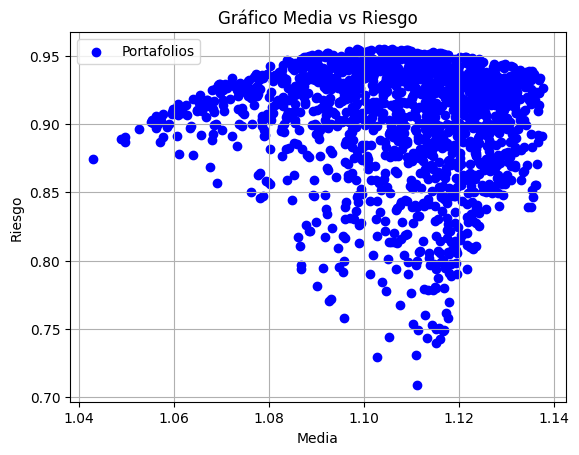

In [66]:
plt.scatter(medias, ESc, color='blue', label='Portafolios')
plt.xlabel("Media")
plt.ylabel("Riesgo")
plt.title("Gráfico Media vs Riesgo")
plt.legend()
plt.grid(True)
plt.show()